In [ ]:


from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import keras as k
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [ ]:
cd '/content/drive/My Drive/recycling waste/'

/content/drive/My Drive/recycling waste


In [ ]:
#load images as np arrays
def load_data(fpath):    
    img=Image.open(fpath).resize((224,224)) # resize to 224x224 for training purposes
    img = np.asarray(img, dtype='float32')
    return img

In [ ]:
import os
import cv2
from tqdm import tqdm
images=[]
labels=[]
DATADIR = '/content/drive/My Drive/recycling waste/'

CATEGORIES = ["batteries", "clothes", "e-waste", "glass", "light blubs", "metal", "organic", "paper", "plastic"]

for category in CATEGORIES:  
    path = os.path.join(DATADIR,category)  
    for img in os.listdir(path):  
        img_array = cv2.imread(os.path.join(path,img) ,cv2.COLOR_BGR2RGB)
        try:
          img_array = cv2.resize(img_array, (224,224), interpolation = cv2.INTER_AREA)
          if img_array.shape == (224,224,3):
            images.append(img_array)
            labels.append(category)
        except:
          break
        


In [ ]:
images = np.asarray(images) # all of the images are converted to np array of (1360,224,224,3)
#images = np.vstack(images)


In [ ]:
#images /= 255.

In [ ]:
images.shape

(8073, 224, 224, 3)

In [ ]:
target_dict={k: v for v, k in enumerate(np.unique(labels))}
target_dict

{'batteries': 0,
 'clothes': 1,
 'e-waste': 2,
 'glass': 3,
 'light blubs': 4,
 'metal': 5,
 'organic': 6,
 'paper': 7,
 'plastic': 8}

In [ ]:
label =  [target_dict[labels[i]] for i in range(len(labels))]

In [ ]:
label_ = np.asarray(label).reshape(8073,1) # labels are also converted to (1360,1)
label_.shape

(8073, 1)

In [ ]:
label_

array([[0],
       [0],
       [0],
       ...,
       [8],
       [8],
       [8]])

In [ ]:
#prepare train test

images_train = images[:7000]
label_train = label_[:7000]

images_test = images[7001:8073]
label_test = label_[7001:8073]

In [ ]:
print(images_train.shape)
print(label_train.shape)

print(images_test.shape)
print(label_test.shape)

(7000, 224, 224, 3)
(7000, 1)
(1072, 224, 224, 3)
(1072, 1)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

gen_train = ImageDataGenerator(rescale = 1/255, shear_range = 0.2, zoom_range = 0.2, 
                               brightness_range = (0.1, 0.5), horizontal_flip=True)

train_data = gen_train.flow_from_directory("/content/drive/My Drive/recycling waste/",
                                           target_size = (224, 224), batch_size = 32, class_mode="categorical")

In [ ]:
train_data.image_shape


(224, 224, 3)

In [ ]:

train_dataset = tf.data.Dataset.from_tensor_slices(
            (image_train.astype(np.float32), label_train.astype(np.int32))
        )

test_dataset = tf.data.Dataset.from_tensor_slices(
            (image_test.astype(np.float32), label_test.astype(np.int32))
        )

In [ ]:
learning_rate = 0.001
meta_step_size = 0.10 
#0.25

inner_batch_size = 25
eval_batch_size = 25

meta_iters = 100 #2000
eval_iters = 5
inner_iters = 4

eval_interval = 1
train_shots = 20 #20
shots = 10
classes = 9


In [ ]:
def get_mini_dataset(
       batch_size, repetitions, shots, num_classes,labels, split=False
    ):
        temp_labels = np.zeros(shape=(num_classes * shots))
        temp_images = np.zeros(shape=(num_classes * shots, 224, 224, 3))
        if split:
            test_labels = np.zeros(shape=(num_classes))
            test_images = np.zeros(shape=(num_classes, 224, 224, 3))

        # Get a random subset of labels from the entire label set.
        label_subset = random.choices(labels, k=num_classes)
        for class_idx, class_obj in enumerate(label_subset):
            # Use enumerated index value as a temporary label for mini-batch in
            # few shot learning.
            temp_labels[class_idx * shots : (class_idx + 1) * shots] = class_idx
            # If creating a split dataset for testing, select an extra sample from each
            # label to create the test dataset.
            if split:
                test_labels[class_idx] = class_idx
                images_to_split = random.choices(
                    images_test[label_subset[class_idx]], k=shots + 1
                )
                test_images[class_idx] = images_to_split[-1]
                temp_images[
                    class_idx * shots : (class_idx + 1) * shots
                ] = images_to_split[:-1]
            else:
                # For each index in the randomly selected label_subset, sample the
                # necessary number of images.
                temp_images[
                    class_idx * shots : (class_idx + 1) * shots
                ] = random.choices(images_train[label_subset[class_idx]], k=shots)

        dataset = tf.data.Dataset.from_tensor_slices(
            (temp_images.astype(np.float32), temp_labels.astype(np.int32))
        )
        dataset = dataset.shuffle(100).batch(batch_size).repeat(repetitions)
        if split:
            return dataset, test_images, test_labels
        return dataset

In [ ]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
model = Sequential([
  Conv2D(filters=128, kernel_size=2, strides=2,padding = 'same', input_shape=(224, 224, 3)),
  layers.BatchNormalization(),
  layers.ReLU(),
  Conv2D(filters=64, kernel_size=2, strides=2,padding = 'same'),
  layers.BatchNormalization(),
  layers.ReLU(),
  Conv2D(filters=32, kernel_size=2, strides=2,padding = 'same'),
  layers.BatchNormalization(),
  layers.ReLU(),
  Dropout(0.5), 
  Conv2D(filters=32, kernel_size=2, strides=2,padding = 'same'),
  layers.BatchNormalization(),
  layers.ReLU(),
  Dropout(0.5),
  Flatten(),
  Dense(classes, activation='softmax'),
])

#model = keras.Model(inputs=inputs, outputs=outputs)
model.compile()
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 112, 112, 128)     1664      
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 128)     512       
_________________________________________________________________
re_lu (ReLU)                 (None, 112, 112, 128)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 56, 56, 64)        32832     
_________________________________________________________________
batch_normalization_1 (Batch (None, 56, 56, 64)        256       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        8

In [ ]:
training = []
testing = []
for meta_iter in range(meta_iters):
    frac_done = meta_iter / meta_iters
    cur_meta_step_size = (1 - frac_done) * meta_step_size
    # Temporarily save  weights from the model.
    old_vars = model.get_weights()
    # Get a sample from the dataset.
    mini_dataset = get_mini_dataset(
        inner_batch_size, inner_iters, train_shots, classes, label_
    )
    for images, labels in mini_dataset:
        with tf.GradientTape() as tape:
            preds = model(images)
            loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
    new_vars = model.get_weights()
    # Perform SGD for the meta step.
    for var in range(len(new_vars)):
        new_vars[var] = old_vars[var] + (
            (new_vars[var] - old_vars[var]) * cur_meta_step_size
        )
    model.set_weights(new_vars)
    # Evaluation loop
    if meta_iter % eval_interval == 0:
        accuracies = []
        for dataset in (images_train, images_test):
            # Sample a mini dataset.
            train_set, test_images, test_labels = get_mini_dataset(
                eval_batch_size, eval_iters, shots, classes,label_, split=True
            )
            old_vars = model.get_weights()
            for images, labels in train_set:
                with tf.GradientTape() as tape:
                    preds = model(images)
                    loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
                grads = tape.gradient(loss, model.trainable_weights)
                optimizer.apply_gradients(zip(grads, model.trainable_weights))
            test_preds = model.predict(test_images)
            test_preds = tf.argmax(test_preds).numpy()
            num_correct = (test_preds == test_labels).sum()
            model.set_weights(old_vars)
            accuracies.append(num_correct / classes)
        training.append(accuracies[0])
        testing.append(accuracies[1])
        if meta_iter % 10 == 0:
            print(
                "batch %d: train=%f test=%f" % (meta_iter, accuracies[0], accuracies[1])
            )


batch 0: train=0.777778 test=0.666667
batch 10: train=0.666667 test=0.666667
batch 20: train=0.444444 test=0.666667
batch 30: train=0.777778 test=0.555556
batch 40: train=0.666667 test=0.666667
batch 50: train=0.555556 test=0.666667
batch 60: train=0.666667 test=0.666667
batch 70: train=0.777778 test=0.555556
batch 80: train=0.666667 test=0.444444
batch 90: train=0.555556 test=0.333333


In [ ]:
from tensorflow.keras.preprocessing import image
output_class = ["batteries", "clothes", "e-waste", "glass", "light blubs", "metal", "organic", "paper", "plastic"]
def waste_prediction(new_image):
  test_image = image.load_img(new_image, target_size = (224,224))
  plt.axis("off")
  plt.imshow(test_image)
  plt.show()
 
  test_image = image.img_to_array(test_image) / 255
  test_image = np.expand_dims(test_image, axis=0)

  predicted_array = model.predict(test_image)
  predicted_value = output_class[np.argmax(predicted_array)]
  predicted_accuracy = round(np.max(predicted_array) * 100, 2)

  print("Your waste material is ", predicted_value, " with ", predicted_accuracy, " % accuracy")

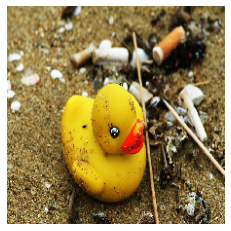

Your waste material is  paper  with  11.13  % accuracy


In [ ]:
waste_prediction('/content/toy.jpg')

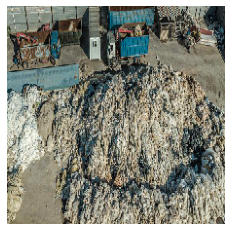

Your waste material is  paper  with  11.13  % accuracy


In [ ]:
test_image = image.load_img('/content/drive/MyDrive/recycling waste/plastic/above-view-mountains-plastic-waste-fruit-vegetable-growing-greenhouses-andalusia-169905526.jpg', target_size = (224,224))
plt.axis("off")
plt.imshow(test_image)
plt.show()
 
test_image = image.img_to_array(test_image) / 255
test_image = np.expand_dims(test_image, axis=0)

predicted_array = model.predict(test_image)
#y_pred =  predicted_array.argmax(axis=-1)
#test_preds = model.predict(test_image)
#test_preds = tf.argmax(test_preds).numpy()
#num_correct = (test_preds == test_labels).sum()
predicted_value = output_class[np.argmax(predicted_array)]
predicted_accuracy = round(np.max(predicted_array) * 100, 2)

print("Your waste material is ", predicted_value, " with ", predicted_accuracy, " % accuracy")
#print("Your waste material is ", predicted_value)

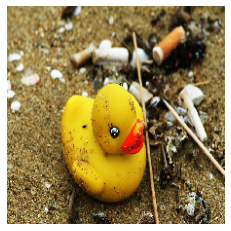

In [ ]:
test_image = image.load_img('/content/toy.jpg', target_size = (224,224))
plt.axis("off")
plt.imshow(test_image)
plt.show()

test_image = image.img_to_array(test_image) / 255
test_image = np.expand_dims(test_image, axis=0)

In [ ]:
shot = 10
classes = 9
eval_batch_size = 2
eval_iters = 100
#test_image =np.asarray(test_image)


predict_model = get_mini_dataset(
                eval_batch_size, eval_iters, shots, classes,label_, split= False
            )
           # old_vars = model.get_weights()
            # Train on the samples and get the resulting accuracies.
for images, labels in predict_model:
  with tf.GradientTape() as tape:
    preds = model(images)
    loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
  grads = tape.gradient(loss, model.trainable_weights)
  optimizer.apply_gradients(zip(grads, model.trainable_weights))
test_preds = model.predict(test_image)
print(test_preds)
#test_preds = tf.argmax(test_preds).numpy()
predicted_value = output_class[np.argmax(test_preds)]
predicted_accuracy = round(np.max(test_preds) * 100, 2)
num_correct = (test_preds == test_labels).sum()
#print(num_correct/classes)
print("The waste material is ", predicted_value)

[[0.11883976 0.109928   0.10747252 0.11056013 0.11306304 0.11362658
  0.10591117 0.1115717  0.1090271 ]]
The waste material is  batteries


In [ ]:
test_preds

array([[0.11031219, 0.11428112, 0.09680009, 0.11133363, 0.11947551,
        0.10673247, 0.12100288, 0.11141048, 0.10865172]], dtype=float32)

In [ ]:
model.save('/content/garbage_model.h5')

In [ ]:
predict_model

<RepeatDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>